In [29]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import joblib

from astropy.io import fits
from functools import reduce
from astropy.table import Table

sys.path.append('../../methods_code_Nresol/')
sys.path.append('../../utils/')
import astro_cuts
import importlib
import spec_utils

In [30]:
dat = Table.read('lsd_scripts/spectrain_2_11_r50.fits', format='fits')

In [31]:
np.unique(np.array(dat['sdss_dr17_specobj.CLASS']))

array([b'GALAXY', b'QSO', b'STAR'], dtype='|S6')

In [32]:
fname = 'lsd_scripts/spectrain_2_11_r50.fits'
df_allspec = spec_utils.convert_to_dataframe_specmatched(fname)

/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:36: RuntimeWarning: divide by zero encountered in true_divide
  df['reduced_chisq'] = df['chisq'].to_numpy() * n_passbands / (n_passbands - 4)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:40: RuntimeWarning: divide by zero encountered in power
  sdss_flux_sig = np.power(np.array(dat['sdss_dr14_starsweep.psfflux_ivar']), -0.5)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:42: RuntimeWarning: divide by zero encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]), 0.0, np.inf)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:42: RuntimeWarning: invalid value encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]),

In [33]:
importlib.reload(spec_utils)

<module 'spec_utils' from '/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py'>

In [34]:
df_goodspec = spec_utils.return_goodspec(df_allspec)

Number of objects before / after 596315 210713
c1 = 0.873, c2 = 0.995, c3 = 0.445
Fraction left = 0.353


<Figure size 640x480 with 0 Axes>

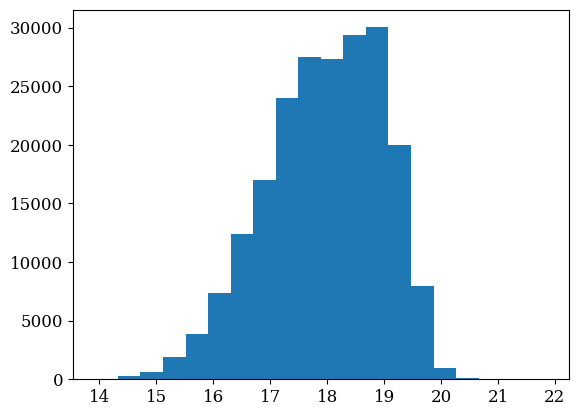

In [51]:
plt.figure()
plt.hist(df_goodspec['gaia_edr3.phot_g_mean_mag'].to_numpy(), bins=20)
plt.show()

## Section 1: 
### How many objects are not stars before cuts?

In [35]:
importlib.reload(spec_utils)
#make a table for this instead

<module 'spec_utils' from '/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py'>

In [36]:
spec_utils.print_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'])

Number of Stars = 175597, Fraction(%) = 83.3347, Ratio(obj:star)*100 = 100
Number of Galaxies = 299, Fraction(%) = 0.1419, Ratio(obj:star)*100 = 0.1703
Number of QSOs = 34817, Fraction(%) = 16.5234, Ratio(obj:star)*100 = 19.8278


In [37]:
df_goodspec['sdss_dr17_specobj.CLASS'].unique()

array([b'QSO', b'STAR', b'GALAXY'], dtype=object)

In [38]:
galmask = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'GALAXY'
qsomask = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'QSO'

In [39]:
plt.rcParams.update({'font.family':'serif', 'font.size': 12})

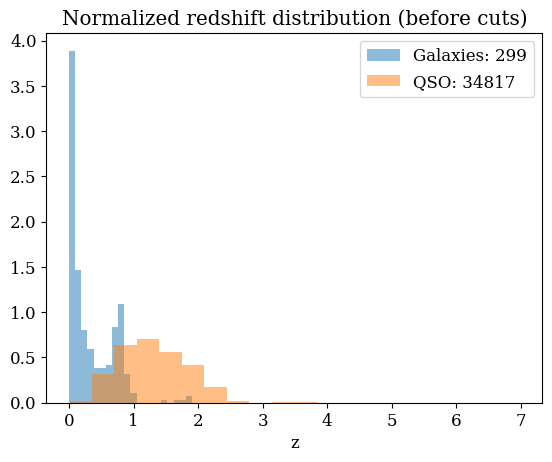

In [40]:
galz = df_goodspec.iloc[galmask, :]['sdss_dr17_specobj.Z']
quaz = df_goodspec.iloc[qsomask, :]['sdss_dr17_specobj.Z']
plt.figure()
plt.hist(galz, bins=20, label='Galaxies: {}'.format(np.sum(galmask)), alpha=0.5, density=True)
plt.hist(quaz, bins=20, label='QSO: {}'.format(np.sum(qsomask)), alpha=0.5, density=True)
plt.xlabel('z')
plt.legend()
plt.title('Normalized redshift distribution (before cuts)')
plt.savefig('../../plots/zdbn_before.pdf')
plt.show()

### After cuts: 16a

In [41]:
nbtest_dir = '../../notebooks_test/'

def combine_cuts(df_input, cuts_list):
    cutfuncs = [getattr(astro_cuts, ctup[0]) for ctup in cuts_list]
    masklist = []
    for c, ctup in enumerate(cuts_list):
        if len(ctup)==1:
            masklist.append(cutfuncs[c](df_input))
        else:
            masklist.append(cutfuncs[c](df_input, **ctup[1]))
        print('Cut{} {} {}'.format(c, np.sum(masklist[c]), np.sum(masklist[c])/len(masklist[c])))
    final_cut = reduce(np.logical_and, masklist) #intersection of all cuts
    print('Effective Cut = {:.3f}'.format(np.sum(final_cut)/len(final_cut)))
    return final_cut

In [42]:
os.listdir('models')

['.ipynb_checkpoints',
 'svm_sdss_quasarsep_unbalanced.joblib',
 'svm_panstarrs_quasarsep_balanced.joblib',
 'svm_sdss_quasarsep_balanced.joblib']

In [43]:
wisemodel = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')
smodel = joblib.load('models/svm_sdss_quasarsep_unbalanced.joblib')

cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]

final_cut = combine_cuts(df_goodspec, cuts_list) #intersection of all cuts
df15k = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(df15k['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Cut3 210106 0.997119304456773
Cut4 175386 0.8323454177008538
Cut5 156011 0.740395704109381
Effective Cut = 0.667
Number of Stars = 140519, Fraction(%) = 99.9232, Ratio(obj:star)*100 = 100
Number of Galaxies = 55, Fraction(%) = 0.0391, Ratio(obj:star)*100 = 0.0391
Number of QSOs = 53, Fraction(%) = 0.0377, Ratio(obj:star)*100 = 0.0377


In [44]:
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], df15k['sdss_dr17_specobj.CLASS'])

StarFracChange = 16.589 (%)
GalFracChange = -0.103 (%)
QSOFracChange = -16.486 (%)
Stars thrown out = -35078


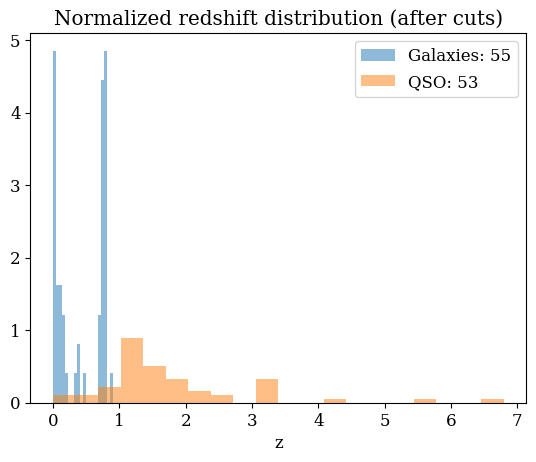

In [47]:
galmask = df15k['sdss_dr17_specobj.CLASS'].to_numpy()==b'GALAXY'
qsomask = df15k['sdss_dr17_specobj.CLASS'].to_numpy()==b'QSO'
galz = df15k.iloc[galmask, :]['sdss_dr17_specobj.Z']
quaz = df15k.iloc[qsomask, :]['sdss_dr17_specobj.Z']

plt.figure()
plt.hist(galz, bins=20, label='Galaxies: {}'.format(np.sum(galmask)), alpha=0.5, density=True)
plt.hist(quaz, bins=20, label='QSO: {}'.format(np.sum(qsomask)), alpha=0.5, density=True)
plt.xlabel('z')
plt.legend()
plt.title('Normalized redshift distribution (after cuts)')
plt.savefig('../../plots/zdbn_after.pdf')
plt.show()

#### Magnitude dbn

In [64]:
galmaskpre = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'GALAXY'
qsomaskpre = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'QSO'

In [65]:
exgalmaskpre = galmaskpre + qsomaskpre

In [62]:
exgalmask = galmask+qsomask

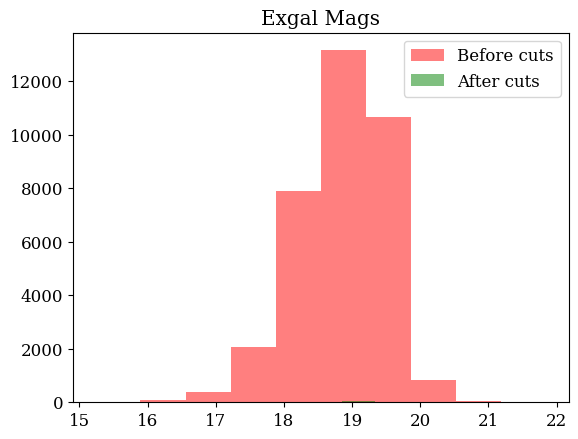

In [75]:
plt.figure()
plt.hist(df_goodspec.iloc[exgalmaskpre, :]['gaia_edr3.phot_g_mean_mag'].to_numpy(), color='r', bins=10, alpha=0.5, label='Before cuts')
plt.hist(df15k.iloc[exgalmask, :]['gaia_edr3.phot_g_mean_mag'].to_numpy(), color='g', bins=10, alpha=0.5, label='After cuts')
plt.legend()
plt.title('Exgal Mags')
plt.show()

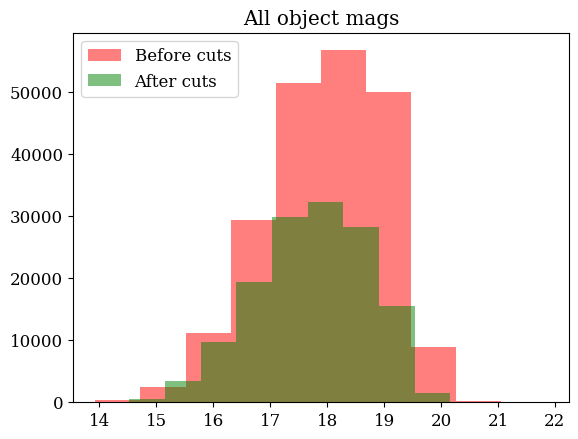

In [76]:
plt.figure()
plt.hist(df_goodspec['gaia_edr3.phot_g_mean_mag'].to_numpy(), color='r', bins=10, alpha=0.5, label='Before cuts')
plt.hist(df15k['gaia_edr3.phot_g_mean_mag'].to_numpy(), color='g', bins=10, alpha=0.5, label='After cuts')
plt.legend()
plt.title('All object mags')
plt.show()